# **Requirements Installation**

In [ ]:
!pip install kaggle
!pip install -q findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz && rm spark-3.1.2-bin-hadoop3.2.tgz

# **Imports**

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import TimestampType 
from pyspark.sql.functions import col,isnan, when, count

# **Connecting Drive to google colab**

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# **Downoloading Dataset from kaggle**

In [ ]:
!mkdir -p ~/.kaggle
!cp /gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Downloading Dataset
!kaggle competitions download -c ashrae-energy-prediction --force
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

 94% 113M/120M [00:04<00:00, 18.8MB/s]
100% 120M/120M [00:04<00:00, 28.1MB/s]
 98% 163M/167M [00:04<00:00, 35.0MB/s]
100% 167M/167M [00:04<00:00, 37.4MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 79.9MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 43.5MB/s]
 89% 79.0M/88.4M [00:02<00:00, 18.9MB/s]
100% 88.4M/88.4M [00:02<00:00, 31.2MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 42.4MB/s]
Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  weather_test.csv.zip
  inflating: weather_test.csv        

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  weather_train.csv.zip
  inflating: weather_train.csv       

5 archives were successfully processed.


# **Initialize Spark session**

In [ ]:
findspark.find()
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

# **Load Data**

In [ ]:
# Load data
train = spark.read.csv('/content/train.csv', header=True, inferSchema=True)
test = spark.read.csv('/content/test.csv', header=True, inferSchema=True)
weather_train = spark.read.csv('/content/weather_train.csv', header=True, inferSchema=True)
weather_test = spark.read.csv('/content/weather_test.csv', header=True, inferSchema=True)
build_meta = spark.read.csv('/content/building_metadata.csv', header=True, inferSchema=True)

In [ ]:
#@title
# Print dataframes schema
train.printSchema()
test.printSchema()
weather_train.printSchema()
weather_test.printSchema()
build_meta.printSchema()

root
 |-- building_id: integer (nullable = true)
 |-- meter: integer (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- meter_reading: double (nullable = true)

root
 |-- row_id: integer (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- meter: integer (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- site_id: integer (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- air_temperature: double (nullable = true)
 |-- cloud_coverage: double (nullable = true)
 |-- dew_temperature: double (nullable = true)
 |-- precip_depth_1_hr: double (nullable = true)
 |-- sea_level_pressure: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)

root
 |-- site_id: integer (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- air_temperature: double (nullable = true)
 |-- cloud_coverage: double (nullable = true)
 |-- dew_temperature: double (nullable = true)
 |-- precip_depth_

In [ ]:

# Merge Data and delete unused dataframes

train_merged = train.join(build_meta,['building_id'],how='left')
train_merged = train_merged.join(weather_train,["site_id", "timestamp"],how='left')
test_merged = test.join(build_meta,['building_id'],how='left')
test_merged = test_merged.join(weather_test,["site_id", "timestamp"],how='left')
del weather_train, weather_test,build_meta# 

In [ ]:

train_merged_rows = train_merged.count()
test_merged_rows = test_merged.count()
train_merged_columns = len(train_merged.columns)
test_merged_columns = len(test_merged.columns)
                          
print(train_merged_rows, train_merged_columns)
print(test_merged_rows, test_merged_columns)

20216100 16
41697600 16


In [10]:
# The train dataset contains a 'timestamp' type string column we convert to a timestamp object for ease of use
train_merged = train_merged.withColumn("timestamp",train_merged["timestamp"].cast(TimestampType()))
test_merged = test_merged.withColumn("timestamp",test_merged["timestamp"].cast(TimestampType()))

In [11]:
train_merged.printSchema()
test_merged.printSchema()

root
 |-- site_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- meter: integer (nullable = true)
 |-- meter_reading: double (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: double (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- floor_count: double (nullable = true)
 |-- air_temperature: double (nullable = true)
 |-- cloud_coverage: double (nullable = true)
 |-- dew_temperature: double (nullable = true)
 |-- precip_depth_1_hr: double (nullable = true)
 |-- sea_level_pressure: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)

root
 |-- site_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- meter: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: double (nulla

In [12]:
train_merged.show()

+-------+-------------------+-----------+-----+-------------+--------------------+-----------+----------+-----------+---------------+--------------+---------------+-----------------+------------------+--------------+----------+
|site_id|          timestamp|building_id|meter|meter_reading|         primary_use|square_feet|year_built|floor_count|air_temperature|cloud_coverage|dew_temperature|precip_depth_1_hr|sea_level_pressure|wind_direction|wind_speed|
+-------+-------------------+-----------+-----+-------------+--------------------+-----------+----------+-----------+---------------+--------------+---------------+-----------------+------------------+--------------+----------+
|      0|2016-01-01 00:00:00|          0|    0|          0.0|           Education|     7432.0|      2008|       null|           25.0|           6.0|           20.0|             null|            1019.7|           0.0|       0.0|
|      0|2016-01-01 00:00:00|          1|    0|          0.0|           Education|     2

In [13]:
# Percentage of null data in every feature
train_merged.select([((count(when(col(c).isNull(), c))*100)/train_merged_rows).alias(c) for c in train_merged.columns]
   ).show()

test_merged.select([((count(when(col(c).isNull(), c))*100)/test_merged_rows).alias(c) for c in test_merged.columns]
   ).show()

+-------+---------+-----------+-----+-------------+-----------+-----------+-----------------+----------------+-------------------+-----------------+-------------------+------------------+------------------+----------------+------------------+
|site_id|timestamp|building_id|meter|meter_reading|primary_use|square_feet|       year_built|     floor_count|    air_temperature|   cloud_coverage|    dew_temperature| precip_depth_1_hr|sea_level_pressure|  wind_direction|        wind_speed|
+-------+---------+-----------+-----+-------------+-----------+-----------+-----------------+----------------+-------------------+-----------------+-------------------+------------------+------------------+----------------+------------------+
|    0.0|      0.0|        0.0|  0.0|          0.0|        0.0|        0.0|59.99003269671203|82.6527718006935|0.47812387156771086|43.65513130623612|0.49534776737352904|18.544739094088374| 6.092515371411895|7.16779200736047|0.7107008770237583|
+-------+---------+---------

# **Exploratory Data Analysis (EDA)**

In [14]:
from pyspark.sql.functions import *
newdf = train_merged.select(year(train_merged.timestamp).alias('dt_year'), month(train_merged.timestamp).alias('dt_month'),train_merged.meter,train_merged.meter_reading)
months_reading = newdf.groupby(['dt_month','meter']).agg(mean("meter_reading").alias("avg_meter_reading"))
# months_reading.show()


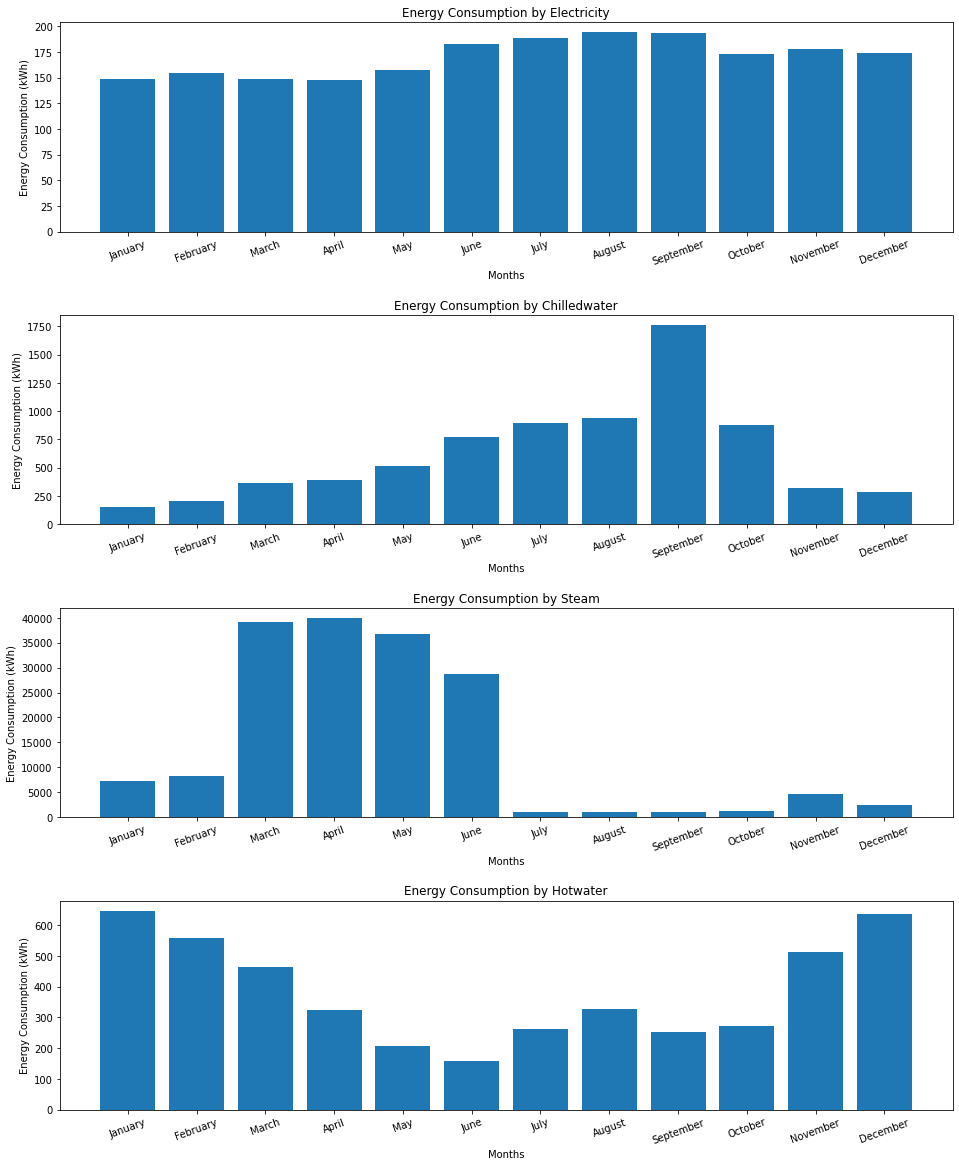

In [15]:
# Explore average meter consumption monthly

months_title = ['January','February','March','April','May','June','July','August','September','October','November','December']
meter_types_names = ['electricity','chilledwater','steam','hotwater']
meter_types = [0,1,2,3]
chart_rows = len(meter_types)
size = (16,chart_rows * 5)
fig,ax = plt.subplots(chart_rows,1,figsize=size)

for i,meter in enumerate(meter_types):
    month_meters = months_reading.filter(months_reading.meter==meter)
    plt.subplot(chart_rows,1,i+1)
    plt.title('Energy Consumption by '+ str.capitalize(meter_types_names[meter]))
    avg_meter_reading = month_meters.select('avg_meter_reading').collect()
    dt_month = month_meters.select('dt_month').collect()
    plt.bar([int(row.dt_month) for row in dt_month],[int(row.avg_meter_reading) for row in avg_meter_reading])
    plt.ylabel('Energy Consumption (kWh)')
    plt.xlabel('Months')
    plt.xticks(np.arange(1,13),months_title, rotation=20)

fig.subplots_adjust(hspace=.4)
plt.show()

*Energy consumption by electricity is average on all months there is no peaks here as electricity consumption doesn't depend much on the seasons, As we observe Energy consumption by hotwater peaks at winter's monthes as predicted, While by observing Chilled water we found that peaks during summer's monthes. All of that says that is the month is a good feature to predict on it.*

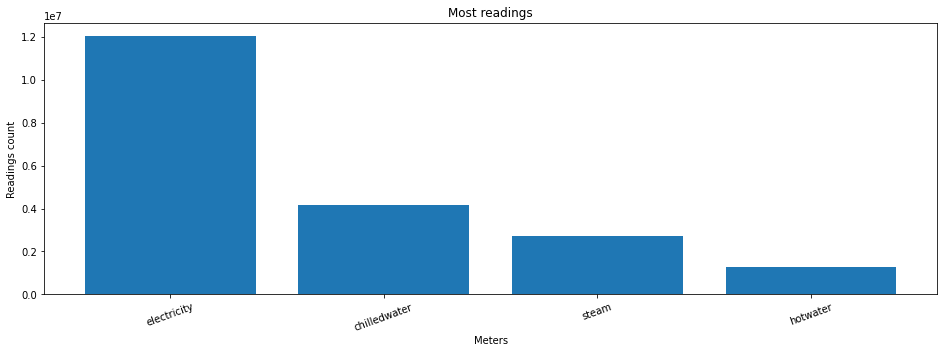

In [16]:
# Explore which type have most readings

newdf = train_merged.select(train_merged.meter,train_merged.meter_reading)
meters_reading = newdf.groupby(['meter']).count()
meters_reading = meters_reading.orderBy("meter")
#meters_reading.show()

meter_types_names = ['electricity','chilledwater','steam','hotwater']
meter_types = [0,1,2,3]
size = (16, 5)
fig,ax = plt.subplots(1,1,figsize=size)
plt.subplot(1,1,1)
plt.title('Most readings')
avg_meter_reading = meters_reading.select('meter').collect()
values = meters_reading.select('count').collect()
#print(avg_meter_reading,values)
plt.bar(meter_types,[int(row[0]) for row in values])
plt.ylabel('Readings count')
plt.xlabel('Meters')
plt.xticks(np.arange(0,4),meter_types_names, rotation=20)

fig.subplots_adjust(hspace=.4)
plt.show()

*Most readings mesure electricity.*

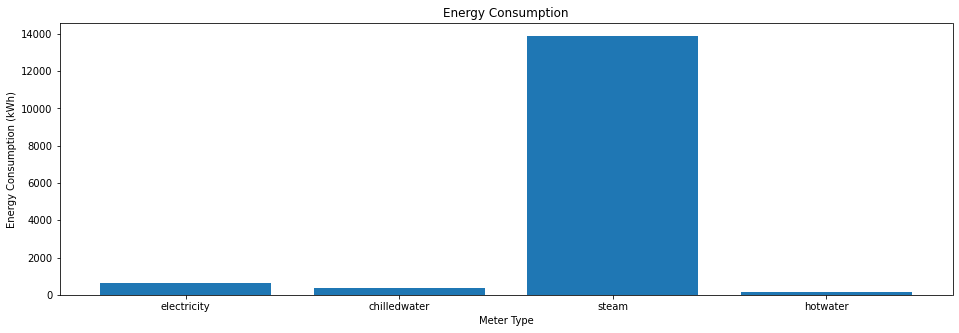

In [17]:
# Explore which type generation consumes more energy
newdf = train_merged.select(train_merged.meter,train_merged.meter_reading)
meters_reading = newdf.groupby(['meter']).agg(mean("meter_reading").alias("avg_meter_reading"))
size = (16,5)
fig,ax = plt.subplots(1,1,figsize=size)
#meters_reading.show()
avg_meter_reading = meters_reading.select('avg_meter_reading').collect()
plt.subplot(1,1,1)
plt.title('Energy Consumption')
plt.bar(meter_types_names,[int(row.avg_meter_reading) for row in avg_meter_reading])
#plt.ylim(0,1e10)
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Meter Type')
#plt.xticks(np.arange(0,5),meter_types_names, rotation=20)

fig.subplots_adjust(hspace=.3)
plt.show()


*Generating Steam Consumes most energy*

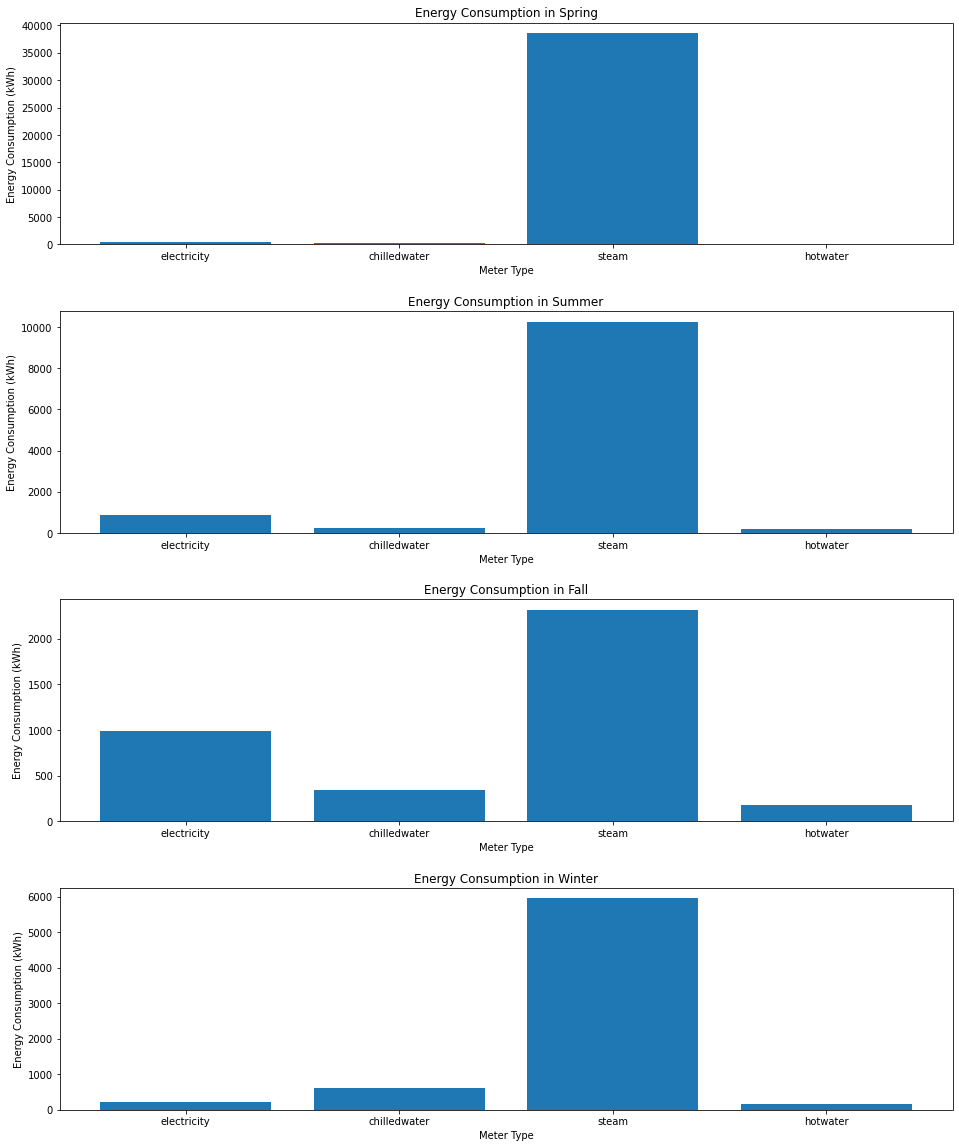

In [18]:
# Explore average meter consumption Seasonally

spring= ('spring',[3,4,5])
summer= ('summer',[6,7,8])
fall= ('fall',[9,10,11])
winter= ('winter',[1,2,12])
seasons = [spring,summer,fall,winter]
chart_rows = len(seasons)
size = (16,chart_rows * 5)
fig,ax = plt.subplots(chart_rows,1,figsize=size)
for i,season in enumerate(seasons):
    season_name, season_months = season
    month_meters = months_reading.filter(months_reading.dt_month.isin(season_months))
    month_meters = month_meters.groupby(['meter']).agg(mean("avg_meter_reading").alias("avg_meter_reading"))
    avg_meter_reading = month_meters.select('avg_meter_reading').collect()
    plt.subplot(chart_rows,1,i+1)
    plt.title('Energy Consumption in ' + str.capitalize(season_name))
    plt.bar(meter_types_names,[int(row.avg_meter_reading) for row in avg_meter_reading])
    #plt.ylim(0,1e10)
    plt.ylabel('Energy Consumption (kWh)')
    plt.xlabel('Meter Type')
    #plt.xticks(np.arange(0,5),meter_types_names, rotation=20)

fig.subplots_adjust(hspace=.3)
plt.show()

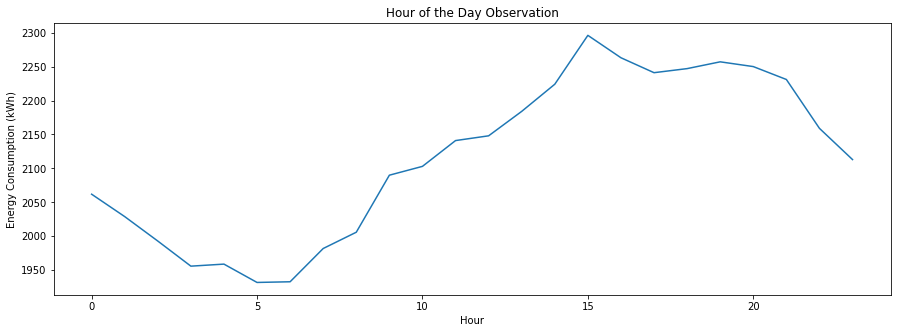

In [19]:
# Explore Energy consumption Hourly
newdf_2 = train_merged.select(hour(train_merged.timestamp).alias('dt_hour'),train_merged.meter,train_merged.meter_reading)
hour_reading = newdf_2.groupby(['dt_hour']).agg(mean("meter_reading").alias("avg_meter_reading"))
hour_reading = hour_reading.orderBy("dt_hour")
plt.figure(figsize=(15,5))
plt.title('Hour of the Day Observation')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Hour')
avg_meter_reading = hour_reading.select('avg_meter_reading').collect()
dt_hour = hour_reading.select('dt_hour').collect()
#print([int(row.dt_hour) for row in dt_hour],[int(row.avg_meter_reading) for row in avg_meter_reading])
plt.plot([int(row.dt_hour) for row in dt_hour],[int(row.avg_meter_reading) for row in avg_meter_reading])
plt.show()

*Reading is much higher during regular work hours, as expected.*

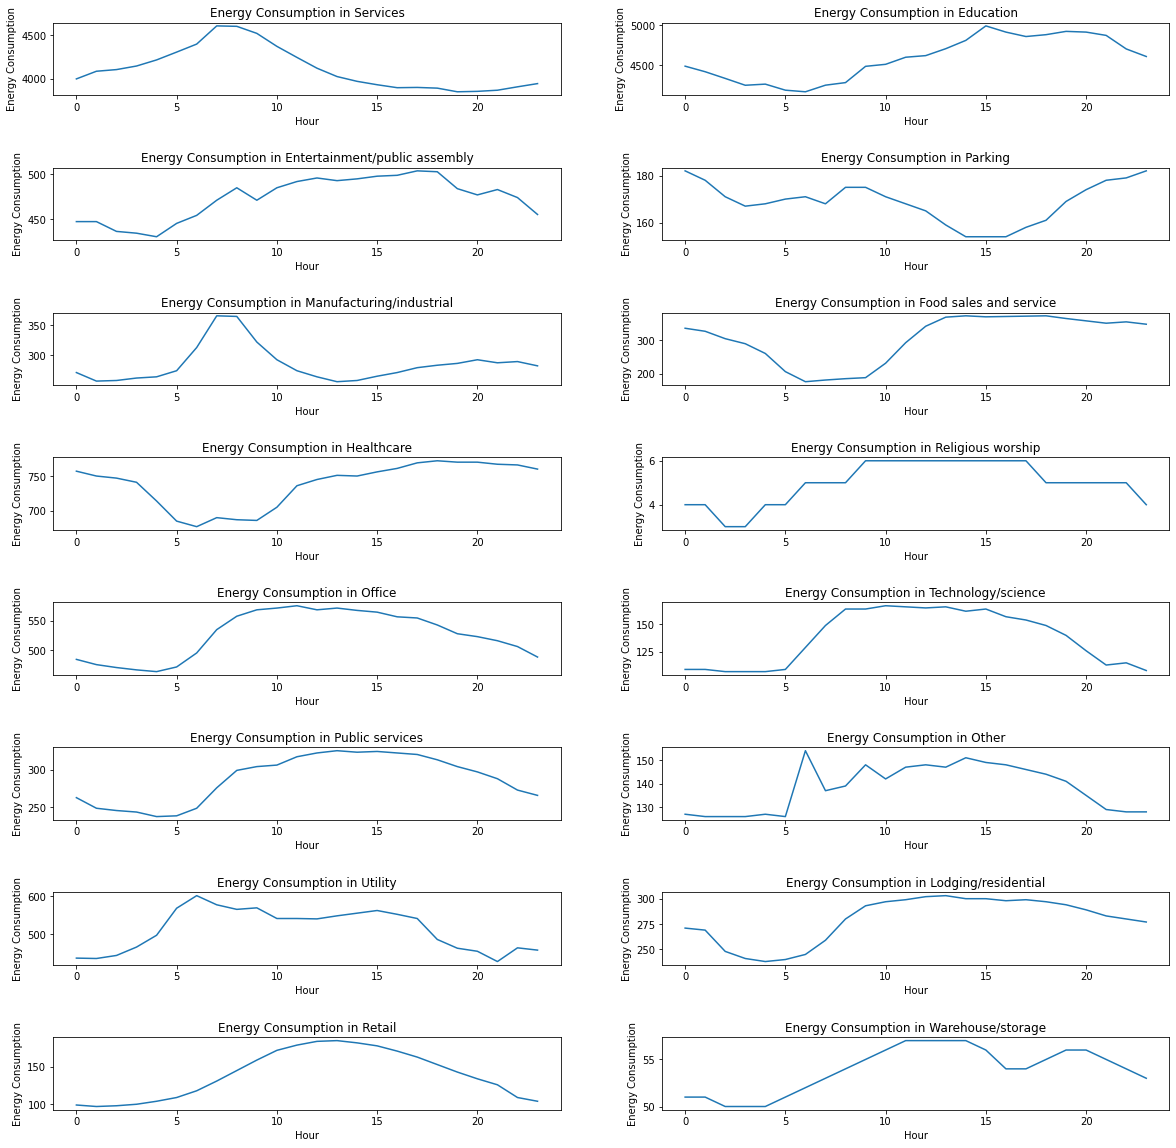

In [20]:
# Explore Energy consumption Hourly with type of building
primary_use_names = train_merged.select('primary_use').distinct().collect()
primary_use_names = [row.primary_use for row in primary_use_names]
#print(primary_use_names)
newdf_2 = train_merged.select(hour(train_merged.timestamp).alias('dt_hour'),train_merged.primary_use,train_merged.meter_reading)
hour_reading_type = newdf_2.groupby(['dt_hour','primary_use']).agg(mean("meter_reading").alias("avg_meter_reading"))
hour_reading_type = hour_reading_type.orderBy("primary_use","dt_hour")
chart_rows = len(primary_use_names)
size = (20, 20)
fig,ax = plt.subplots(8,2,figsize=size)
for i,primary_use in enumerate(primary_use_names):
    hour_reading_prim = hour_reading_type.filter(hour_reading_type.primary_use==primary_use)
    avg_meter_reading = hour_reading_prim.select('avg_meter_reading').collect()
    dt_hour = hour_reading_prim.select('dt_hour').collect()
    plt.subplot(8,2,i+1)
    plt.title('Energy Consumption in ' + str.capitalize(primary_use))
    plt.plot([int(row.dt_hour) for row in dt_hour],[int(row.avg_meter_reading) for row in avg_meter_reading])
    #plt.ylim(0,1e10)
    plt.ylabel('Energy Consumption')
    plt.xlabel('Hour')
fig.subplots_adjust(hspace=1)
plt.show()

*Religious worship locations consume least amount of energy - they are undoubtedly visited less frequently than the others. We also observe that healthcare, Education and and services consume much more amount of energy. Which Primary use is an important feature to predict on it*